# Voting Classifier con los mejores 3 modelos obtenidos

Como modelo adicional a los considerados, utilizaremos un modelo ensamblado considerando los 3 mejores modelos obtenidos al momento de entrenamiento. Así, en este notebook utilizaremos el voto de los 3 mejores modelos para obtener la predicción de las fallas y así posteriormente, evaluar el desempeño para entrar en comparación con los demás.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from imblearn.under_sampling import RandomUnderSampler

In [2]:
current_dir = os.getcwd()
file_name = 'conf.json'
path = os.path.join(current_dir, f'{file_name}')
with open(path, 'r') as f:
    info_conf = json.load(f)
            
base_path = info_conf['base_path']
os.chdir(base_path)

In [3]:
from sklearn.externals import joblib
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from mlxtend.classifier import EnsembleVoteClassifier

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
import scripts.funciones as funciones
from scripts.clase_model.modelo import Modelo

### Organización de la información

Importamos la información incluyendo tanto la ventana de tiempo de entrenamiento como la de prueba. Para esto, organizamos la información acorde a las caracteristicas del modelo entrenado

In [5]:
d_ini = dt.datetime(2017,6,1)
d_fin = dt.datetime(2020,1,1)

In [6]:
version = 'ver012'    
mod_version = funciones.carga_model(base_path, f'models/{version}', version)

if 'model' in mod_version:
    print("Model loaded")
    mod = mod_version['model'].steps[0][1]
    model_sel = mod_version['model'].steps[1][1]
else:
    print("No model found")
    

data = funciones.read_clima_accidentes(d_ini, d_fin, poblado = True)
data_org = funciones.organizar_data_infoClima(data)

### agregamos la informacion relacionada a la cantidad de accidentes ocurridas
### en las ultimas X horas

### En caso que se considere acumulado de fallas, realiza la validacion
### si el modelo entrenado tiene la frecuencia utilizada
try:
    freq1 = mod.freq1
    freq2 = mod.freq2
except Exception as e:
    print(f'Problemas con las frecuencias de las senales {e}')
    freq1 = '1H'
    freq2 = '1H'

d_ini_acc = d_ini - dt.timedelta(hours = int(freq2.replace('H', '')))
raw_accidentes = funciones.read_accidentes(d_ini_acc, d_fin)

### Agrega senal a corto plazo
data_org = funciones.obtener_accidentes_acumulados(data_org, 
                                                    raw_accidentes, 
                                                    freq = freq1)

### Agrega senal a largo plazo
data_org = funciones.obtener_accidentes_acumulados(data_org, 
                                                    raw_accidentes, 
                                                    freq = freq2)

data_org['poblado'] = data_org['BARRIO']
data_org= pd.get_dummies(data_org, columns=['poblado'])

Model loaded


Realizamos la división del conjunto de datos en entrenamiento, validación y prueba.

In [7]:
d_ini_train = dt.datetime(2017,6,1)
d_fin_train = dt.datetime(2019,8,1)  

d_ini_test = dt.datetime(2019,8,1)
d_fin_test = dt.datetime(2020,1,1)

train = (data_org['TW']>= d_ini_train) & (data_org['TW']< d_fin_train)
test = (data_org['TW']>= d_ini_test) & (data_org['TW']< d_fin_test)
    
X_train = data_org[train].drop(columns = ['TW','BARRIO','Accidente','summary']).reset_index(drop = True)
Y_train = data_org[train]['Accidente'].reset_index(drop = True)

X_test = data_org[test].drop(columns = ['TW','BARRIO','Accidente','summary']).reset_index(drop = True)
Y_test = data_org[test]['Accidente'].reset_index(drop = True)

X_train = X_train[mod.cols_order]
X_test = X_test[mod.cols_order]

X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, 
                                        Y_train,
                                        stratify = Y_train,
                                        test_size = 0.2,
                                        random_state = 42)

# Cargar Modelos Entrenamos

Cargamos en memoria los 3 mejores modelos obtenidos, y los ensamblamos en un clasificador que los tomará y en base a la predicción de los 3 modelos, entregará una única predicción de ocurrencia del accidente

In [8]:
mod1 = funciones.carga_model(base_path, f'models/{version}', 'nn_20200505_2014')['model']
mod2 = funciones.carga_model(base_path, f'models/{version}', 'xgboost_20200505_1249')['model']
mod3 = funciones.carga_model(base_path, f'models/{version}', 'logistic_20200505_1249')['model']

In [9]:
VotingClassifier = EnsembleVoteClassifier(clfs=[mod1, mod2, mod3], weights=[1,1,1], refit=False)
VotingClassifier.fit(X_train, Y_train)

EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('nn',
                                              MLPClassifier(activation='logistic',
                                                            alpha=0.1,
                                                            batch_size='auto',
                                                            beta_1=0.9,
                                                            beta_2=0.999,
                                                            early_stopping=False,
                                                            epsilon=1e-08,
                                                            hidden_layer_sizes

Obtenemos las métricas del modelo en el conjunto de validación

In [10]:
preds = VotingClassifier.predict(X_val)
proba = VotingClassifier.predict_proba(X_val)

In [11]:
ROC = metrics.roc_auc_score(Y_val, proba[:,1])
bAccuracy = metrics.balanced_accuracy_score(Y_val,preds) 
fScore = metrics.f1_score(Y_val,preds) 
precision = metrics.precision_score(Y_val,preds)
recall = metrics.recall_score(Y_val,preds)

print(f'ROC-AUC: {ROC}')
print(f'bAccuracy: {bAccuracy}')
print(f'fScore: {fScore}')
print(f'precision: {precision}')
print(f'recall: {recall}')

ROC-AUC: 0.7699789997490519
bAccuracy: 0.6884844571614961
fScore: 0.09074811863656486
precision: 0.04914888515943419
recall: 0.590778097982709


# Evaluación del modelo en el conjunto de prueba

Obtenemos las métricas del modelo en el conjunto de prueba

In [15]:
preds = VotingClassifier.predict(X_test)
proba = VotingClassifier.predict_proba(X_test)

In [16]:
ROC = metrics.roc_auc_score(Y_test, proba[:,1])
bAccuracy = metrics.balanced_accuracy_score(Y_test,preds) 
fScore = metrics.f1_score(Y_test,preds) 
precision = metrics.precision_score(Y_test,preds)
recall = metrics.recall_score(Y_test,preds)

print(f'ROC-AUC: {ROC}')
print(f'bAccuracy: {bAccuracy}')
print(f'fScore: {fScore}')
print(f'precision: {precision}')
print(f'recall: {recall}')

ROC-AUC: 0.7610496799343289
bAccuracy: 0.6789569035314289
fScore: 0.09122639254123835
precision: 0.0494377364357154
recall: 0.5896168108776267


# Lift Plot

In [21]:
%matplotlib notebook

In [19]:
import scikitplot as skplt
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


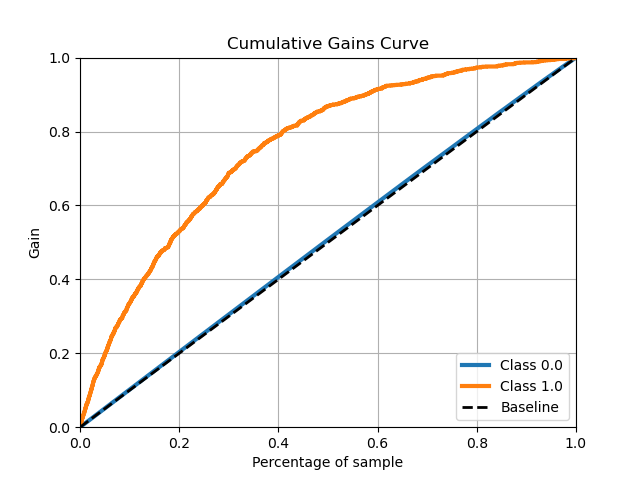

<IPython.core.display.Javascript object>


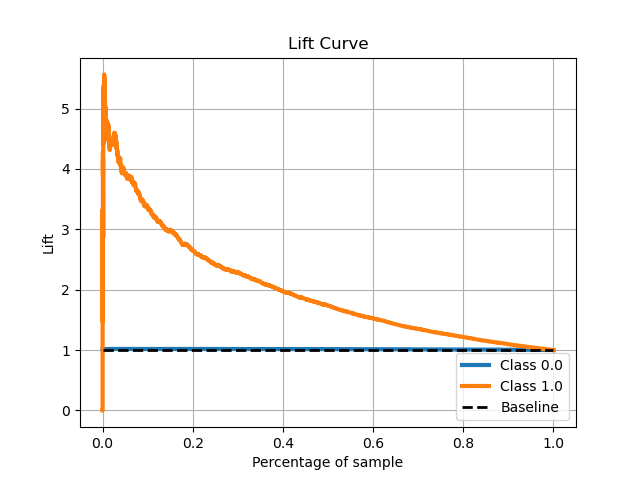

In [22]:
mod1 = funciones.carga_model(base_path, f'models/{version}', 'nn_20200505_2014')['model']

Y_test_pred_ = mod1.predict_proba(X_test)[:]
skplt.metrics.plot_cumulative_gain(Y_test, Y_test_pred_)
plt.show()
skplt.metrics.plot_lift_curve(Y_test, Y_test_pred_)
plt.show()

In [34]:
#X_test
X_test['TW'] = data_org[test]['TW'].values
X_test['BARRIO'] = data_org[test]['BARRIO'].values
X_test['Probabilidad'] = Y_test_pred_[:,1]
X_test['Prediccion_Accidente'] = (X_test['Probabilidad']>=0.5).astype(int)

filt = X_test['TW']== dt.datetime(2019,12,23,13)

In [36]:
X_test[filt][['TW','BARRIO','Probabilidad','Prediccion_Accidente']].reset_index(drop = True)

,TW,BARRIO,Probabilidad,Prediccion_Accidente
0,2019-12-23 13:00:00,alejandria,0.473368,0
1,2019-12-23 13:00:00,altosdelpoblado,0.255721,0
2,2019-12-23 13:00:00,astorga,0.282577,0
3,2019-12-23 13:00:00,barriocolombia,0.618663,1
4,2019-12-23 13:00:00,castropol,0.745842,1
5,2019-12-23 13:00:00,elcastillo,0.337579,0
6,2019-12-23 13:00:00,eldiamanteno2,0.266474,0
7,2019-12-23 13:00:00,elpoblado,0.701477,1
8,2019-12-23 13:00:00,eltesoro,0.555661,1
9,2019-12-23 13:00:00,laaguacatala,0.752611,1


# Preparación de Datos para el modelo de Efectos Mixtos

In [21]:
d_ini_train = dt.datetime(2017,6,1)
d_fin_train = dt.datetime(2019,8,1)  

d_ini_test = dt.datetime(2019,8,1)
d_fin_test = dt.datetime(2020,1,1)

train = (data_org['TW']>= d_ini_train) & (data_org['TW']< d_fin_train)
test = (data_org['TW']>= d_ini_test) & (data_org['TW']< d_fin_test)
    
X_train = data_org[train].drop(columns = ['Accidente','summary']).reset_index(drop = True)
Y_train = data_org[train]['Accidente'].reset_index(drop = True)

X_test = data_org[test].drop(columns = ['Accidente','summary']).reset_index(drop = True)
Y_test = data_org[test]['Accidente'].reset_index(drop = True)

X_train = X_train[['TW','BARRIO',*mod.cols_order]]
X_test = X_test[['TW','BARRIO',*mod.cols_order]]

X_train, X_val, Y_train, Y_val = train_test_split(X_train, 
                                        Y_train,
                                        stratify = Y_train,
                                        test_size = 0.2,
                                        random_state = 42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

Y_train = Y_train.reset_index(drop = True)
Y_val = Y_val.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)


cols = ['TW','BARRIO']

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
scaler.fit(X_train.drop(columns = cols))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
X_train_z = pd.DataFrame(scaler.transform(X_train.drop(columns = cols)), columns = X_train.columns[2:])
X_train_z['BARRIO'] = X_train['BARRIO']
X_train_z['TW'] = X_train['TW']
X_train_z['Accidente'] = Y_train.reset_index(drop = True)

X_val_z = pd.DataFrame(scaler.transform(X_val.drop(columns = cols)), columns = X_val.columns[2:])
X_val_z['BARRIO'] = X_val['BARRIO']
X_val_z['TW'] = X_val['TW']
X_val_z['Accidente'] = Y_val.reset_index(drop = True)

X_test_z = pd.DataFrame(scaler.transform(X_test.drop(columns = cols)), columns = X_test.columns[2:])
X_test_z['BARRIO'] = X_test['BARRIO']
X_test_z['TW'] = X_test['TW']
X_test_z['Accidente'] = Y_test.reset_index(drop = True)

In [25]:
can_0 = len(Y_train) - Y_train.sum()
can_1 = Y_train.sum()  

prop_deseada_under = 0.4

tra_0 = int(len(Y_train) - Y_train.sum())
tra_1 = int(Y_train.sum())

mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)    
fac_1 = int(tra_0 * (1 - mul_updown))


ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)

os_X_tt, os_Y_tt = rus.fit_sample(X_train_z, Y_train)

In [26]:
os_X_tt.to_csv('data/train.csv', sep = ',', index = False)
X_val_z.to_csv('data/validation.csv', sep = ',', index = False)
X_test_z.to_csv('data/test.csv', sep = ',', index = False)

In [20]:
os_X_tt

,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,...,icon_rain,dia_sem_3,dia_sem_4,dia_sem_5,dia_sem_6,humidity_mean,windSpeed_mean,BARRIO,TW,Accidente
0,-0.179910,0.155953,-0.682072,-0.651654,0.811147,1.324059,-0.234747,-0.070940,-0.699668,1.398175,...,-0.614337,2.452102,-0.408977,-0.408304,-0.408073,0.880017,0.227932,alejandria,2019-08-01 00:00:00,0.0
1,-0.403634,-0.173214,-0.723680,-0.676536,0.969364,1.531767,-0.190932,0.419852,-0.699668,1.398175,...,-0.614337,2.452102,-0.408977,-0.408304,-0.408073,1.315654,-0.002315,alejandria,2019-08-01 01:00:00,0.0
2,-0.342425,-0.008630,-0.820764,-0.765003,1.012515,1.739475,-0.164643,0.419852,-0.699668,1.398175,...,-0.614337,2.452102,-0.408977,-0.408304,-0.408073,1.420808,-0.129774,alejandria,2019-08-01 02:00:00,0.0
3,-0.117740,0.361683,-0.926171,-0.867294,0.978953,1.877947,-0.120829,0.321693,-0.699668,1.398175,...,1.627771,2.452102,-0.408977,-0.408304,-0.408073,1.525961,-0.216117,alejandria,2019-08-01 03:00:00,0.0
4,0.119101,0.608558,-1.078732,-1.030406,0.748819,1.877947,-0.261035,0.125377,-0.699668,1.398175,...,1.627771,2.452102,-0.408977,-0.408304,-0.408073,1.676181,-0.214061,alejandria,2019-08-01 04:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80779,3.360337,0.937725,-0.085695,-0.007500,1.726889,1.254823,-0.261035,1.303278,-0.699668,-0.544573,...,1.627771,-0.407813,-0.408977,-0.408304,-0.408073,0.744820,0.495184,villacarlota,2019-12-31 19:00:00,0.0
80780,3.136292,0.978870,-0.232709,-0.167848,1.472783,1.254823,-0.112066,1.303278,-0.699668,-0.381367,...,1.627771,-0.407813,-0.408977,-0.408304,-0.408073,0.955127,0.014131,villacarlota,2019-12-31 20:00:00,0.0
80781,2.087303,1.061162,-0.343663,-0.306078,1.094020,1.116351,-0.331138,1.303278,-0.699668,0.621136,...,1.627771,-0.407813,-0.408977,-0.408304,-0.408073,1.120369,0.001796,villacarlota,2019-12-31 21:00:00,0.0
80782,1.703516,1.061162,-0.551701,-0.552128,0.537863,0.908643,-0.742994,1.303278,-0.699668,1.398175,...,1.627771,-0.407813,-0.408977,-0.408304,-0.408073,1.150413,-0.335352,villacarlota,2019-12-31 22:00:00,0.0


In [ ]:
data_org[['BARRIO','Accidente']].groupby('BARRIO').sum().sort_values(by = 'Accidente',ascending = False)